# FAISS Example 04: HNSW Graph Visualization
# Ví dụ 4: Trực quan hóa HNSW Graph-based Search

Notebook này minh họa:
- Cách HNSW (Hierarchical Navigable Small World) hoạt động
- Visualization của graph structure và hierarchical layers
- Trade-off giữa M, efConstruction, efSearch
- So sánh HNSW vs IVF
- Performance analysis và tuning guide

In [32]:
import numpy as np
import faiss
import matplotlib.pyplot as plt
import seaborn as sns
import time
import networkx as nx
from sklearn.decomposition import PCA
import sys
import os

sys.path.append(os.path.dirname(os.path.abspath('')))
from utils.data_generator import generate_random_vectors, generate_query_vectors
from utils.benchmark import benchmark_index, progressive_recall_benchmark, compare_indexes
from utils.visualization import plot_recall_vs_time

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Imports hoàn tất!")

✓ Imports hoàn tất!


## 1. HNSW Theory - Lý thuyết

### Cách hoạt động của HNSW:

```
Layer 2 (top):     A ←→ E          (sparse, long-range connections)
                   ↓    ↓
Layer 1:       A ←→ C ←→ E ←→ G    (medium density)
               ↓    ↓    ↓    ↓
Layer 0 (base): A-B-C-D-E-F-G-H   (dense, all vectors, short-range)
```

### Key Parameters:
- **M**: Số connections mỗi node (16-64, thường dùng 32)
- **efConstruction**: Quality khi build (40-200)
- **efSearch**: Quality khi search (16-512, tune runtime)

### Search Process:
1. Start từ entry point ở layer cao nhất
2. Greedy search xuống từng layer
3. Maintain dynamic list của efSearch candidates
4. Return k nearest neighbors từ layer 0

## 2. Setup và Data

In [33]:
# Configuration
dimension = 128
n_vectors = 50000
n_queries = 200
k = 10

# HNSW parameters
M = 32
efConstruction = 40
efSearch = 16

print(f"Configuration:")
print(f"  Dimension: {dimension}")
print(f"  Database: {n_vectors:,} vectors")
print(f"  Queries: {n_queries}")
print(f"  k: {k}")
print(f"\nHNSW Parameters:")
print(f"  M: {M}")
print(f"  efConstruction: {efConstruction}")
print(f"  efSearch: {efSearch}")

# Generate data
np.random.seed(42)
database_vectors = generate_random_vectors(n_vectors, dimension)
query_vectors = generate_query_vectors(n_queries, dimension)

print(f"\n✓ Data ready")

Configuration:
  Dimension: 128
  Database: 50,000 vectors
  Queries: 200
  k: 10

HNSW Parameters:
  M: 32
  efConstruction: 40
  efSearch: 16

✓ Data ready


## 3. Build Indexes (Flat + HNSW + IVF)

In [34]:
# 1. Flat for ground truth
print("[1/3] Building Flat index...")
index_flat = faiss.IndexFlatL2(dimension)
index_flat.add(database_vectors)
gt_distances, gt_indices = index_flat.search(query_vectors, k)
print(f"  ✓ Ground truth ready\n")

# 2. HNSW
print("[2/3] Building HNSW index...")
start = time.time()
index_hnsw = faiss.IndexHNSWFlat(dimension, M)
index_hnsw.hnsw.efConstruction = efConstruction
index_hnsw.add(database_vectors)
index_hnsw.hnsw.efSearch = efSearch
hnsw_build_time = time.time() - start
print(f"  ✓ Build time: {hnsw_build_time:.3f}s")
print(f"  ✓ Max level: {index_hnsw.hnsw.max_level}")
print(f"  ✓ Entry point: {index_hnsw.hnsw.entry_point}\n")

# 3. IVF for comparison
print("[3/3] Building IVF index...")
nlist = int(np.sqrt(n_vectors))
quantizer = faiss.IndexFlatL2(dimension)
index_ivf = faiss.IndexIVFFlat(quantizer, dimension, nlist)
index_ivf.train(database_vectors)
index_ivf.add(database_vectors)
index_ivf.nprobe = 10
print(f"  ✓ IVF ready (nlist={nlist}, nprobe=10)\n")

print("="*70)
print("All indexes built!")
print("="*70)

[1/3] Building Flat index...
  ✓ Ground truth ready

[2/3] Building HNSW index...
  ✓ Build time: 4.224s
  ✓ Max level: 3
  ✓ Entry point: 20288

[3/3] Building IVF index...
  ✓ IVF ready (nlist=223, nprobe=10)

All indexes built!


## 4. HNSW Graph Structure Analysis

In [35]:
# Analyze HNSW structure
print("HNSW Graph Structure Analysis:\n")

max_level = index_hnsw.hnsw.max_level
entry_point = index_hnsw.hnsw.entry_point

print(f"Graph Information:")
print(f"  Max level: {max_level}")
print(f"  Entry point: {entry_point}")
print(f"  M (connections): {M}")
print(f"  Total vectors: {index_hnsw.ntotal}")

# Estimate connections
# Layer 0: each node has ~2*M connections
# Higher layers: progressively fewer nodes
est_connections = n_vectors * M * 2
graph_memory_mb = (est_connections * 4) / (1024**2)  # Assume 4 bytes per connection

print(f"\nEstimated Graph Properties:")
print(f"  Total connections: ~{est_connections:,}")
print(f"  Graph memory overhead: ~{graph_memory_mb:.2f} MB")
print(f"  Avg connections per node: {M * 2}")

# Visualize layer distribution (theoretical)
layer_nodes = []
for layer in range(max_level + 1):
    # Probability of node being in layer i is (1/M)^i
    prob = (1.0 / M) ** layer
    expected_nodes = int(n_vectors * prob)
    layer_nodes.append(max(1, expected_nodes))
    print(f"  Layer {layer}: ~{expected_nodes:,} nodes")

HNSW Graph Structure Analysis:

Graph Information:
  Max level: 3
  Entry point: 20288
  M (connections): 32
  Total vectors: 50000

Estimated Graph Properties:
  Total connections: ~3,200,000
  Graph memory overhead: ~12.21 MB
  Avg connections per node: 64
  Layer 0: ~50,000 nodes
  Layer 1: ~1,562 nodes
  Layer 2: ~48 nodes
  Layer 3: ~1 nodes


## 5. Visualization - HNSW Layers

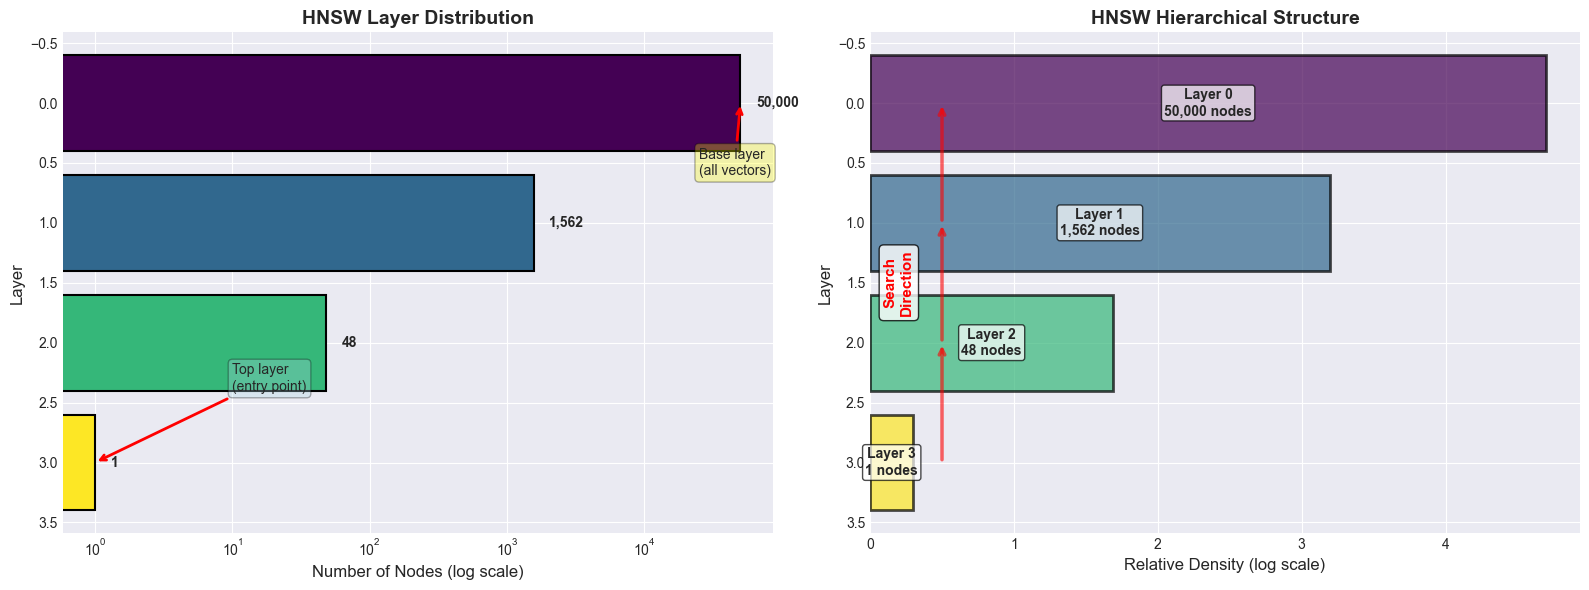

✓ Đã lưu: 04_hnsw_layers.png


In [36]:
# Visualize layer structure
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Layer distribution
ax = axes[0]
layers = list(range(max_level + 1))
colors_grad = plt.cm.viridis(np.linspace(0, 1, len(layers)))

bars = ax.barh(layers, layer_nodes, color=colors_grad, edgecolor='black', linewidth=1.5)
ax.set_xlabel('Number of Nodes (log scale)', fontsize=12)
ax.set_ylabel('Layer', fontsize=12)
ax.set_title('HNSW Layer Distribution', fontsize=14, fontweight='bold')
ax.set_xscale('log')
ax.invert_yaxis()

# Add value labels with better positioning
for i, (bar, count) in enumerate(zip(bars, layer_nodes)):
    # Position text to the right of each bar
    x_pos = count * 1.3
    ax.text(x_pos, i, f'{count:,}', va='center', fontweight='bold', fontsize=10)

# Add annotations with improved positioning
# Base layer annotation
ax.annotate('Base layer\n(all vectors)',
            xy=(layer_nodes[0], 0),
            xytext=(layer_nodes[0]/2, 0.6),
            fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3),
            arrowprops=dict(arrowstyle='->', color='red', lw=2))

# Top layer annotation - handle single node case
top_x_offset = max(layer_nodes[-1] * 3, 10)
ax.annotate('Top layer\n(entry point)',
            xy=(layer_nodes[-1], max_level),
            xytext=(top_x_offset, max_level - 0.6),
            fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.3),
            arrowprops=dict(arrowstyle='->', color='red', lw=2))

# Plot 2: Hierarchical structure visualization
ax = axes[1]

# Draw pyramid-like structure
y_positions = np.arange(max_level + 1)
for i, (layer, nodes) in enumerate(zip(layers, layer_nodes)):
    # Width proportional to log of node count
    width = np.log10(nodes + 1)
    ax.barh(layer, width, height=0.8, color=colors_grad[i],
            edgecolor='black', linewidth=2, alpha=0.7)

    # Add text with better formatting
    ax.text(width/2, layer, f'Layer {layer}\n{nodes:,} nodes',
            ha='center', va='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))

ax.set_xlabel('Relative Density (log scale)', fontsize=12)
ax.set_ylabel('Layer', fontsize=12)
ax.set_title('HNSW Hierarchical Structure', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.set_xlim(0, None)

# Add arrows showing search direction
arrow_x = 0.5
for i in range(max_level):
    ax.annotate('',
                xy=(arrow_x, i),
                xytext=(arrow_x, i + 1),
                arrowprops=dict(arrowstyle='->', color='red', lw=2.5, alpha=0.6))

# Add search direction label
ax.text(arrow_x - 0.3, max_level / 2, 'Search\nDirection',
        fontsize=11, color='red', fontweight='bold',
        rotation=90, va='center', ha='center',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('04_hnsw_layers.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Đã lưu: 04_hnsw_layers.png")

## 6. Trade-off: efSearch vs Recall/Speed

In [37]:
# Benchmark different efSearch values
print("Benchmarking efSearch values...\n")

efSearch_values = [4, 8, 16, 32, 64, 128, 256, 512]
results = progressive_recall_benchmark(
    index_hnsw,
    query_vectors,
    gt_indices,
    'efSearch',
    efSearch_values,
    k
)

# Visualize
plot_recall_vs_time(
    results,
    title='HNSW: efSearch vs Recall/Speed Trade-off',
    save_path='04_efSearch_tradeoff.png'
)

print(f"\n✓ Đã lưu: 04_efSearch_tradeoff.png")

Benchmarking efSearch values...


Progressive benchmark for efSearch:
Value      Recall@10       QPS             Time (s)       
-------------------------------------------------------
4          0.1090          10253.9         0.0195         
8          0.1825          24180.9         0.0083         
16         0.2840          11338.3         0.0176         
32         0.4295          11315.2         0.0177         
64         0.5915          9256.5          0.0216         
128        0.7550          15339.6         0.0130         
256        0.8950          3321.2          0.0602         
512        0.9655          2488.0          0.0804         
  ✓ Đã lưu biểu đồ vào: 04_efSearch_tradeoff.png

✓ Đã lưu: 04_efSearch_tradeoff.png


## 7. Detailed efSearch Analysis

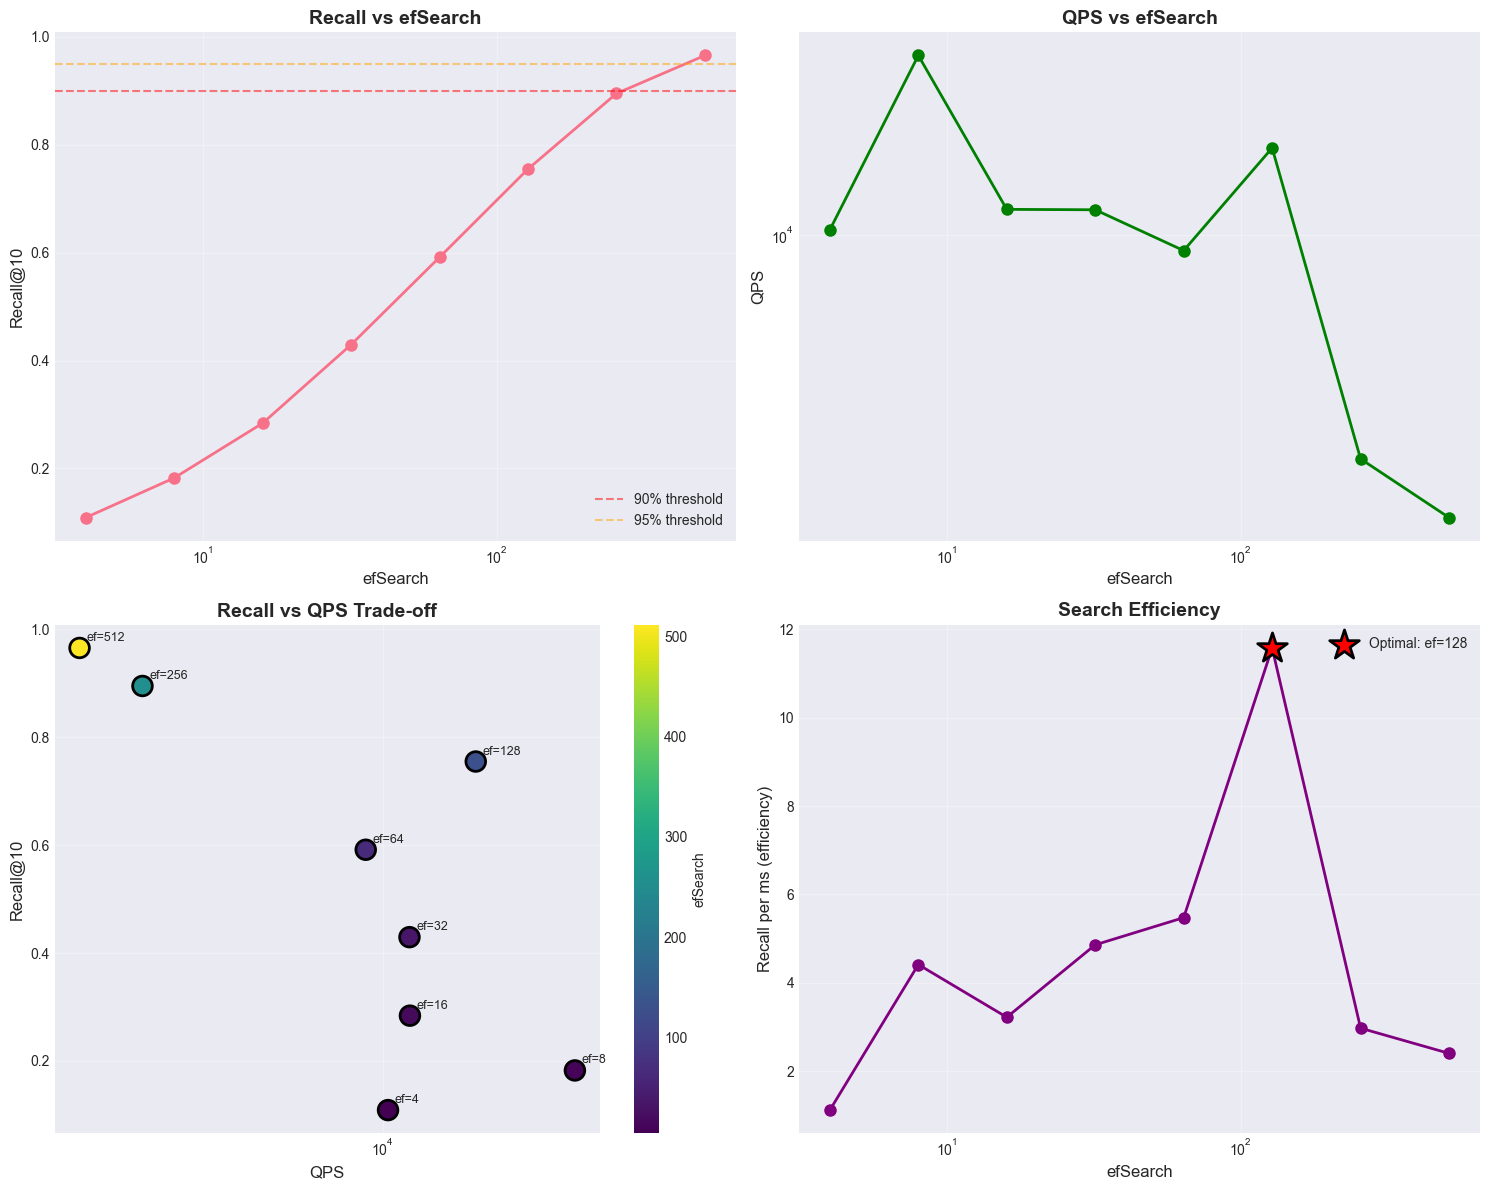

✓ Đã lưu: 04_efSearch_analysis.png

💡 Optimal efSearch: 128 
   Recall: 0.755
   QPS: 15339.6


In [38]:
# Detailed analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Recall curve
ax = axes[0, 0]
ax.plot(efSearch_values, results['recalls'], 'o-', linewidth=2, markersize=8)
ax.axhline(0.9, color='red', linestyle='--', alpha=0.5, label='90% threshold')
ax.axhline(0.95, color='orange', linestyle='--', alpha=0.5, label='95% threshold')
ax.set_xlabel('efSearch', fontsize=12)
ax.set_ylabel('Recall@10', fontsize=12)
ax.set_title('Recall vs efSearch', fontsize=14, fontweight='bold')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)
ax.legend()

# Plot 2: QPS curve
ax = axes[0, 1]
ax.plot(efSearch_values, results['qps'], 'o-', linewidth=2, markersize=8, color='green')
ax.set_xlabel('efSearch', fontsize=12)
ax.set_ylabel('QPS', fontsize=12)
ax.set_title('QPS vs efSearch', fontsize=14, fontweight='bold')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

# Plot 3: Recall vs QPS (Pareto)
ax = axes[1, 0]
scatter = ax.scatter(results['qps'], results['recalls'], 
                     c=efSearch_values, cmap='viridis', 
                     s=200, edgecolors='black', linewidth=2)
for i, ef in enumerate(efSearch_values):
    ax.annotate(f'ef={ef}', 
                (results['qps'][i], results['recalls'][i]),
                xytext=(5, 5), textcoords='offset points', fontsize=9)
ax.set_xlabel('QPS', fontsize=12)
ax.set_ylabel('Recall@10', fontsize=12)
ax.set_title('Recall vs QPS Trade-off', fontsize=14, fontweight='bold')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='efSearch')

# Plot 4: Efficiency (Recall per ms)
ax = axes[1, 1]
avg_latency = [t / len(query_vectors) * 1000 for t in results['search_times']]
efficiency = [r / lat for r, lat in zip(results['recalls'], avg_latency)]
ax.plot(efSearch_values, efficiency, 'o-', linewidth=2, markersize=8, color='purple')
ax.set_xlabel('efSearch', fontsize=12)
ax.set_ylabel('Recall per ms (efficiency)', fontsize=12)
ax.set_title('Search Efficiency', fontsize=14, fontweight='bold')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)

# Mark optimal point
optimal_idx = np.argmax(efficiency)
ax.scatter([efSearch_values[optimal_idx]], [efficiency[optimal_idx]],
           s=500, c='red', marker='*', edgecolors='black', linewidth=2,
           label=f'Optimal: ef={efSearch_values[optimal_idx]}', zorder=5)
ax.legend()

plt.tight_layout()
plt.savefig('04_efSearch_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Đã lưu: 04_efSearch_analysis.png")
print(f"\n💡 Optimal efSearch: {efSearch_values[optimal_idx]} ")
print(f"   Recall: {results['recalls'][optimal_idx]:.3f}")
print(f"   QPS: {results['qps'][optimal_idx]:.1f}")

## 8. Compare Different M Values

In [39]:
# Test different M values
print("Testing different M values...\n")

M_values = [8, 16, 32, 64]
M_results = {
    'M': [],
    'build_time': [],
    'recall': [],
    'qps': [],
    'size_mb': []
}

# Use small subset for faster testing
test_size = 10000
test_vectors = database_vectors[:test_size]
test_queries = query_vectors[:50]

# Ground truth for test set
test_flat = faiss.IndexFlatL2(dimension)
test_flat.add(test_vectors)
_, test_gt = test_flat.search(test_queries, k)

for M_val in M_values:
    print(f"Testing M={M_val}...")
    
    # Build
    start = time.time()
    idx = faiss.IndexHNSWFlat(dimension, M_val)
    idx.hnsw.efConstruction = 40
    idx.add(test_vectors)
    idx.hnsw.efSearch = 64
    build_time = time.time() - start
    
    # Benchmark
    bench = benchmark_index(idx, test_queries, k, test_gt)
    
    # Memory
    from utils.benchmark import get_index_size
    size_info = get_index_size(idx)
    
    # Store
    M_results['M'].append(M_val)
    M_results['build_time'].append(build_time)
    M_results['recall'].append(bench[f'recall@{k}'])
    M_results['qps'].append(bench['qps'])
    M_results['size_mb'].append(size_info['size_mb'])
    
    print(f"  Build: {build_time:.3f}s, Recall: {bench[f'recall@{k}']:.3f}, "
          f"QPS: {bench['qps']:.1f}, Size: {size_info['size_mb']:.2f}MB")

print("\n✓ M comparison complete!")

Testing different M values...

Testing M=8...
  Build: 0.157s, Recall: 0.514, QPS: 63743.2, Size: 5.65MB
Testing M=16...
  Build: 0.177s, Recall: 0.674, QPS: 28842.7, Size: 6.26MB
Testing M=32...
  Build: 0.553s, Recall: 0.878, QPS: 20011.0, Size: 7.47MB
Testing M=64...
  Build: 0.284s, Recall: 0.916, QPS: 16954.9, Size: 9.92MB

✓ M comparison complete!


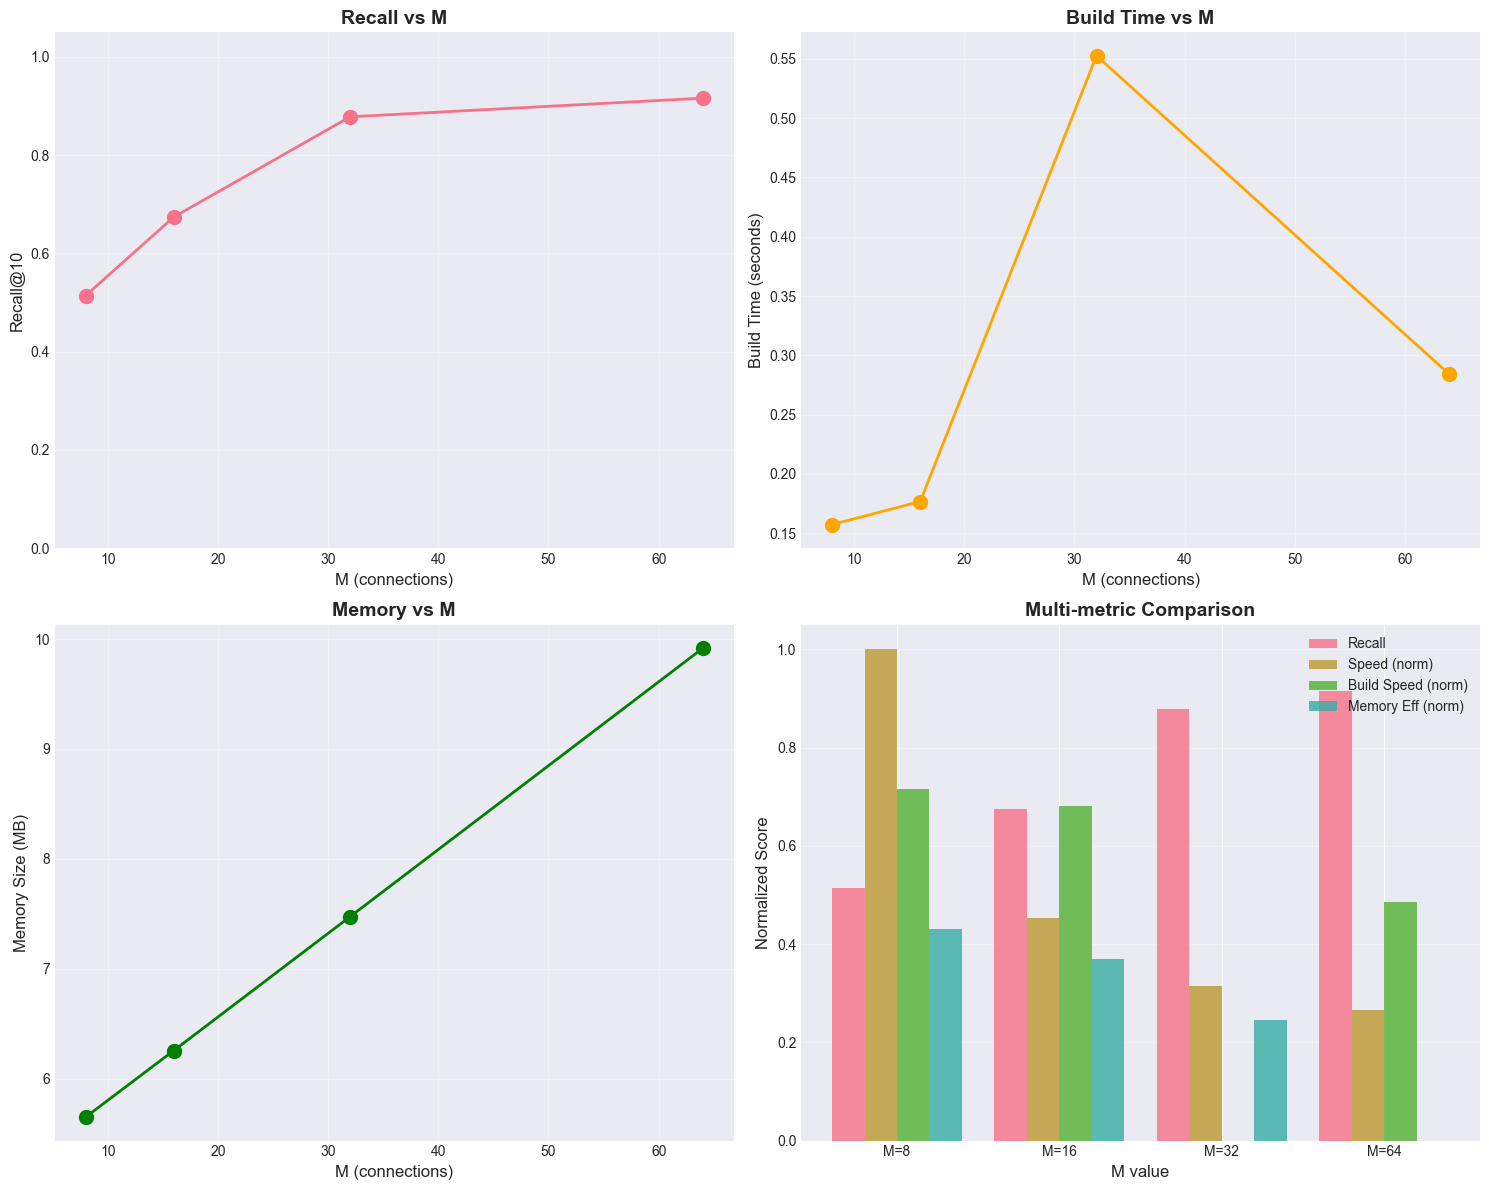

✓ Đã lưu: 04_M_comparison.png


In [40]:
# Visualize M comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Recall vs M
ax = axes[0, 0]
ax.plot(M_results['M'], M_results['recall'], 'o-', linewidth=2, markersize=10)
ax.set_xlabel('M (connections)', fontsize=12)
ax.set_ylabel('Recall@10', fontsize=12)
ax.set_title('Recall vs M', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1.05])

# Plot 2: Build time vs M
ax = axes[0, 1]
ax.plot(M_results['M'], M_results['build_time'], 'o-', 
        linewidth=2, markersize=10, color='orange')
ax.set_xlabel('M (connections)', fontsize=12)
ax.set_ylabel('Build Time (seconds)', fontsize=12)
ax.set_title('Build Time vs M', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 3: Memory vs M
ax = axes[1, 0]
ax.plot(M_results['M'], M_results['size_mb'], 'o-', 
        linewidth=2, markersize=10, color='green')
ax.set_xlabel('M (connections)', fontsize=12)
ax.set_ylabel('Memory Size (MB)', fontsize=12)
ax.set_title('Memory vs M', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 4: Multi-metric radar
ax = axes[1, 1]
# Normalize metrics for comparison
norm_recall = np.array(M_results['recall'])
norm_qps = np.array(M_results['qps']) / max(M_results['qps'])
norm_build = 1 - (np.array(M_results['build_time']) / max(M_results['build_time']))
norm_memory = 1 - (np.array(M_results['size_mb']) / max(M_results['size_mb']))

x = np.arange(len(M_results['M']))
width = 0.2
ax.bar(x - 1.5*width, norm_recall, width, label='Recall', alpha=0.8)
ax.bar(x - 0.5*width, norm_qps, width, label='Speed (norm)', alpha=0.8)
ax.bar(x + 0.5*width, norm_build, width, label='Build Speed (norm)', alpha=0.8)
ax.bar(x + 1.5*width, norm_memory, width, label='Memory Eff (norm)', alpha=0.8)

ax.set_xlabel('M value', fontsize=12)
ax.set_ylabel('Normalized Score', fontsize=12)
ax.set_title('Multi-metric Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'M={m}' for m in M_results['M']])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('04_M_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Đã lưu: 04_M_comparison.png")

## 9. HNSW vs IVF Comparison

In [41]:
# Compare HNSW vs IVF
print("Comparing HNSW vs IVF...\n")

indexes = {
    'Flat': index_flat,
    'HNSW (ef=16)': index_hnsw,
    'IVF (np=10)': index_ivf
}

# Reset efSearch to 16 for fair comparison
index_hnsw.hnsw.efSearch = 16

compare_indexes(indexes, query_vectors, gt_indices, k)

Comparing HNSW vs IVF...


                           Index Comparison                           
Index                Recall@10       QPS             Size (MB)      
----------------------------------------------------------------------
Flat                 1.0000          544.7           24.41          
HNSW (ef=16)         0.2840          43131.3         37.40          
IVF (np=10)          0.2375          7572.2          24.91          



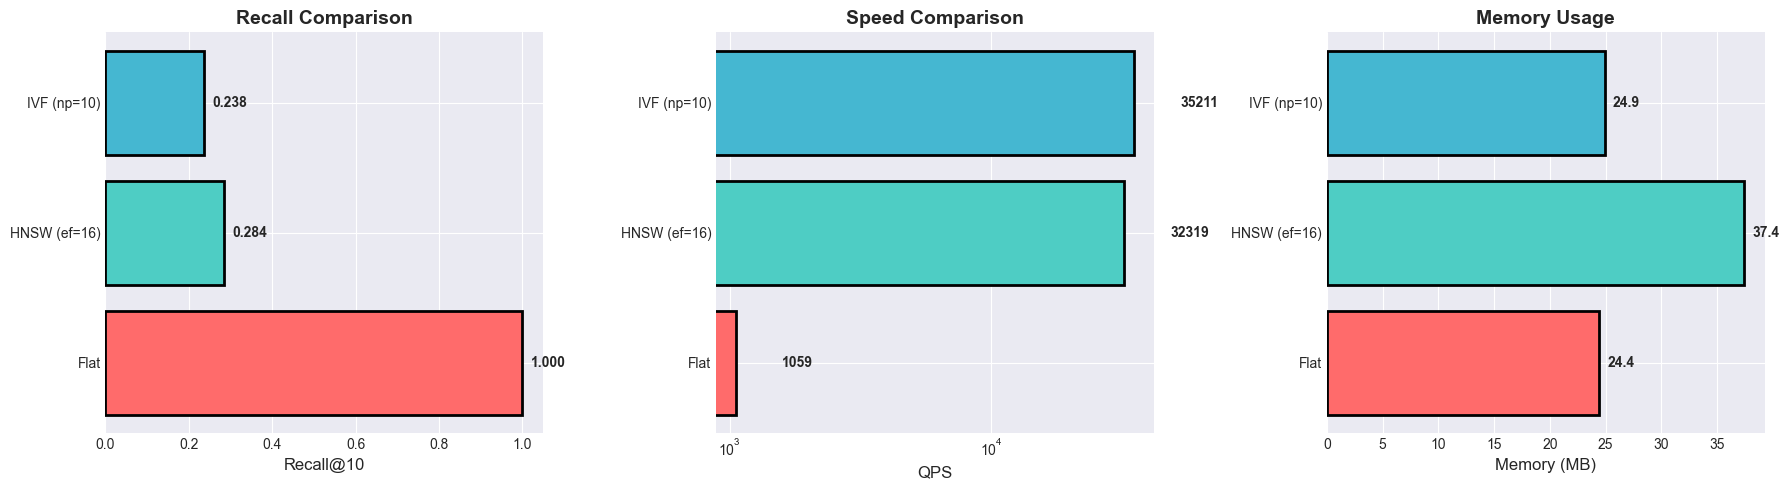

✓ Đã lưu: 04_hnsw_vs_ivf.png


In [42]:
# Detailed visual comparison
from utils.benchmark import get_index_size

comparison = {}
for name, idx in indexes.items():
    bench = benchmark_index(idx, query_vectors, k, gt_indices)
    size = get_index_size(idx)
    comparison[name] = {
        'recall': bench[f'recall@{k}'],
        'qps': bench['qps'],
        'size_mb': size['size_mb']
    }

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

names = list(comparison.keys())
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

# Plot 1: Recall
ax = axes[0]
recalls = [comparison[n]['recall'] for n in names]
bars = ax.barh(names, recalls, color=colors, edgecolor='black', linewidth=2)
ax.set_xlabel('Recall@10', fontsize=12)
ax.set_title('Recall Comparison', fontsize=14, fontweight='bold')
ax.set_xlim([0, 1.05])
for i, (bar, val) in enumerate(zip(bars, recalls)):
    ax.text(val + 0.02, i, f'{val:.3f}', va='center', fontweight='bold')

# Plot 2: QPS
ax = axes[1]
qps_vals = [comparison[n]['qps'] for n in names]
bars = ax.barh(names, qps_vals, color=colors, edgecolor='black', linewidth=2)
ax.set_xlabel('QPS', fontsize=12)
ax.set_title('Speed Comparison', fontsize=14, fontweight='bold')
ax.set_xscale('log')
for i, (bar, val) in enumerate(zip(bars, qps_vals)):
    ax.text(val * 1.5, i, f'{val:.0f}', va='center', fontweight='bold')

# Plot 3: Memory
ax = axes[2]
sizes = [comparison[n]['size_mb'] for n in names]
bars = ax.barh(names, sizes, color=colors, edgecolor='black', linewidth=2)
ax.set_xlabel('Memory (MB)', fontsize=12)
ax.set_title('Memory Usage', fontsize=14, fontweight='bold')
for i, (bar, val) in enumerate(zip(bars, sizes)):
    ax.text(val + max(sizes)*0.02, i, f'{val:.1f}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('04_hnsw_vs_ivf.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Đã lưu: 04_hnsw_vs_ivf.png")

## 10. Summary và Recommendations

In [43]:
print("="*80)
print("HNSW SUMMARY AND RECOMMENDATIONS".center(80))
print("="*80)

print(f"\n📊 HNSW Index Performance:")
print(f"  Build time: {hnsw_build_time:.3f}s for {n_vectors:,} vectors")
print(f"  Max level: {max_level}")
print(f"  Graph layers: {max_level + 1}")
print(f"  Total connections: ~{est_connections:,}")

print(f"\n🎯 Parameter Guidelines:")
print(f"\n  M (connections per node):")
print(f"    • Range: 16-64")
print(f"    • Recommended: 32")
print(f"    • Higher M → Better accuracy, more memory")
print(f"    • Lower M → Faster build, less memory")

print(f"\n  efConstruction (build quality):")
print(f"    • Range: 40-200")
print(f"    • Recommended: 40 (fast) to 100 (quality)")
print(f"    • Higher → Better index quality, slower build")
print(f"    • Set once during build")

print(f"\n  efSearch (search quality):")
print(f"    • Range: 16-512")
print(f"    • Recommended: 16 (fast) to 128 (accurate)")
print(f"    • Higher → Better recall, slower search")
print(f"    • **Can tune at runtime!**")

# Find best efSearch from results
target_recall_idx = next((i for i, r in enumerate(results['recalls']) if r >= 0.95), -1)
if target_recall_idx >= 0:
    print(f"\n  💡 For 95% recall:")
    print(f"     efSearch = {efSearch_values[target_recall_idx]}")
    print(f"     QPS = {results['qps'][target_recall_idx]:.1f}")

print(f"\n⚖️ HNSW vs IVF:")
print(f"\n  Use HNSW when:")
print(f"    ✓ Dataset < 10M vectors")
print(f"    ✓ Need very high accuracy (>95%)")
print(f"    ✓ Memory is available")
print(f"    ✓ Low latency is critical")
print(f"    ✓ Don't want to retrain")

print(f"\n  Use IVF when:")
print(f"    ✓ Dataset > 10M vectors")
print(f"    ✓ Memory is constrained")
print(f"    ✓ Can accept 90-95% recall")
print(f"    ✓ Need to combine with PQ")

print(f"\n🚀 Production Tips:")
print(f"  1. Build offline with high efConstruction (100-200)")
print(f"  2. Start with efSearch=16, increase if needed")
print(f"  3. Monitor latency and tune efSearch dynamically")
print(f"  4. Use M=32 as default, adjust based on benchmarks")
print(f"  5. Consider sharding if dataset > 10M vectors")

print(f"\n💾 Memory Considerations:")
print(f"  • Base vectors: {database_vectors.nbytes / (1024**2):.2f} MB")
print(f"  • Graph overhead: ~{graph_memory_mb:.2f} MB")
print(f"  • Total: ~{(database_vectors.nbytes / (1024**2)) + graph_memory_mb:.2f} MB")
print(f"  • Ratio: {1 + graph_memory_mb/(database_vectors.nbytes / (1024**2)):.2f}x")

print(f"\n" + "="*80)
print(f"✅ HNSW is excellent for high-accuracy, low-latency search!")
print(f"="*80)

                        HNSW SUMMARY AND RECOMMENDATIONS                        

📊 HNSW Index Performance:
  Build time: 4.224s for 50,000 vectors
  Max level: 3
  Graph layers: 4
  Total connections: ~3,200,000

🎯 Parameter Guidelines:

  M (connections per node):
    • Range: 16-64
    • Recommended: 32
    • Higher M → Better accuracy, more memory
    • Lower M → Faster build, less memory

  efConstruction (build quality):
    • Range: 40-200
    • Recommended: 40 (fast) to 100 (quality)
    • Higher → Better index quality, slower build
    • Set once during build

  efSearch (search quality):
    • Range: 16-512
    • Recommended: 16 (fast) to 128 (accurate)
    • Higher → Better recall, slower search
    • **Can tune at runtime!**

  💡 For 95% recall:
     efSearch = 512
     QPS = 2488.0

⚖️ HNSW vs IVF:

  Use HNSW when:
    ✓ Dataset < 10M vectors
    ✓ Need very high accuracy (>95%)
    ✓ Memory is available
    ✓ Low latency is critical
    ✓ Don't want to retrain

  Use IVF